# Perceptron, Adaline, and Optimization

In [9]:
# inline plotting instead of popping out
%matplotlib inline

import os, math
from IPython.display import Image
import numpy as np
seed = np.random.seed

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x = X[y == cl, 0],
            y = X[y == cl, 1],
            alpha = 0.8,
            c = [cmap(idx)], # Prevents warning
            marker = markers[idx],
            label = cl
        )

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='lightgray',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set', edgecolors='k')

# Data preparation

In [2]:
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases/iris/iris.data',
    header = None
)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print('#Training data points: {}'.format(X_train.shape[0]))
print('#Testing data points: {}'.format(X_test.shape[0]))
print('Class labels: {} (mapped from {}'.format(np.unique(y), np.unique(df['Class label'])))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 100
#Testing data points: 50
Class labels: [0 1 2] (mapped from ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


# Standardization for Gradient Descent
Recall from the lecture that the gradient descent may perform poorly if the Hessian of the function  f  to be minimized has a large condition number. In this case, the surface of  f  can be curvy in some directions but flat in the others. Therefore, the gradient descent, which ignores the curvatures, may overshoot the optimal point along curvy directions but take too small step along flat ones.

In [3]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training Perceptron via Scikit-learn and Testing

In [4]:
# max_iter : The maximum number of passes over the training data
# eta0 : learning rate
ppn = Perceptron(max_iter=10, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, max_iter=10)

In [5]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 5
Accuracy: 0.90


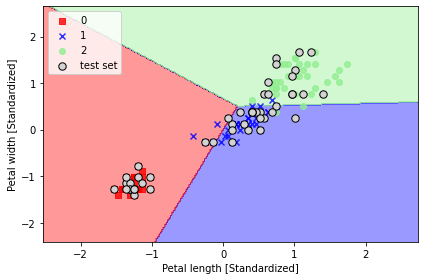

In [12]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('./output/fig-perceptron-scikit.png', dpi=300)
plt.show()

# Implementing Perceptron

In [13]:
class Perceptron2(object):
    """Perceptron classifier.
    
    Parameters
    ------------
    eta: float 
        Learning rate (between 0.0 and 1.0)
    n_iter: int
        Number of epochs, i.e., passes over the training dataset.
        
    Attributes
    ------------
    w_: 1d-array
        Weights after fitting.
    errors_: list
        Number of misclassifications in every epoch.
    random_state : int
        The seed of the pseudo random number generator.
    """
    
    def __init__(self, eta=0.01, n_iter=10, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values, or labels.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0.0
            for xi, yi in zip(X, y):
                output = self.predict(xi)
                error = (yi - output)
                self.w_[1:] += self.eta * error * xi
                self.w_[0] += self.eta * error
                errors += int(error != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [14]:
# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

#Training data points: 90
#Testing data points: 10
Class labels: [-1  1]


Misclassified samples: 3
Accuracy: 0.70


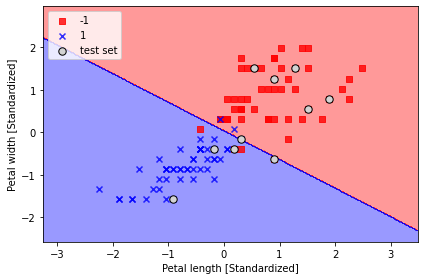

In [15]:
# training

ppn2 = Perceptron2(eta=0.1, n_iter=20)

ppn2.fit(X_train_std, y_train)

# testing

y_pred = ppn2.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot descision boundary

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined, 
                      classifier=ppn2, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-perceptron2-boundary.png', dpi=300)
plt.show()

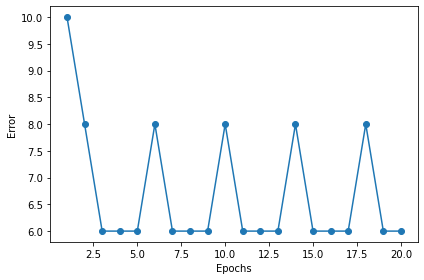

In [16]:
plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error')

plt.tight_layout()
plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()

# Implementing Adaline with GD

In [17]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.activation(X)
            
            # Cost function
            error = (y - output)
            cost = (error**2).sum() / 2.0
            self.cost_.append(cost)
            
            # Update rule
            self.w_[1:] += self.eta * X.T.dot(error)
            self.w_[0] += self.eta * error.sum()
            
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

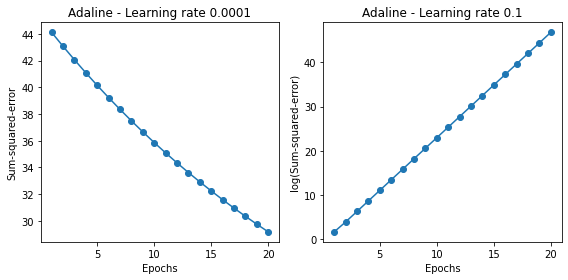

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=20, eta=0.0001).fit(X_train_std, y_train)
ax[0].plot(range(1, len(ada1.cost_) + 1), ada1.cost_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Sum-squared-error')
ax[0].set_title('Adaline - Learning rate 0.0001')

ada2 = AdalineGD(n_iter=20, eta=0.1).fit(X_train_std, y_train)
ax[1].plot(range(1, len(ada2.cost_) + 1), np.log10(ada2.cost_), marker='o') # log is for amplify the overshoot effect
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.1')

plt.tight_layout()
plt.savefig('./output/fig-adaline-gd-overshoot.png', dpi=300)
plt.show()

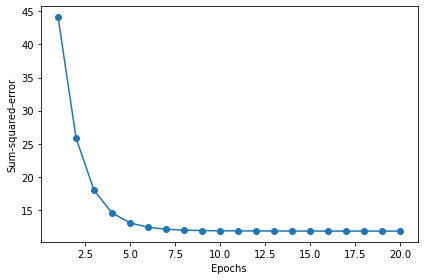

Misclassified samples: 2
Accuracy: 0.80


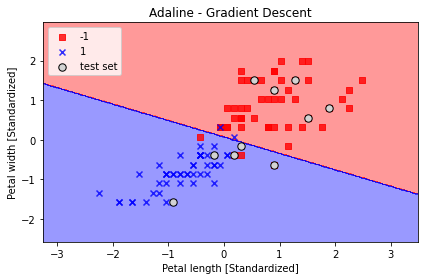

In [22]:
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision boundary 

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=ada, test_idx=range(len(y_train),
                                                    len(y_train) + len(y_test)))
plt.title('Adaline - Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-gd-boundary.png', dpi=300)
plt.show()

# Implementing Adaline with SGD

In [23]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state : seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, yi in zip(X, y):
                cost.append(self._update_weights(xi, yi))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        
        # Cost function
        error = (yi - output)
        cost = 0.5 * error**2
        
        # Update rule
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

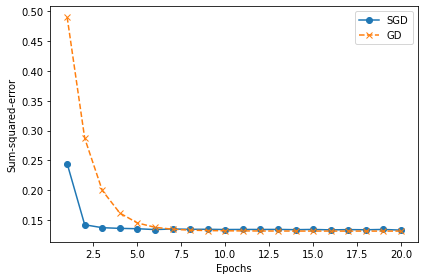

Misclassified samples: 2
Accuracy: 0.80


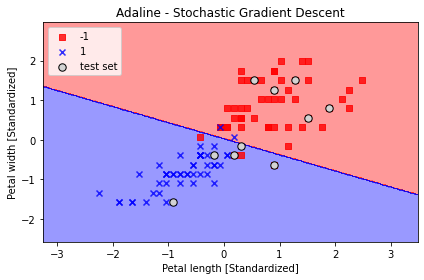

In [24]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# Cost values
plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD')
plt.plot(range(1, len(ada.cost_) + 1), np.array(ada.cost_) / len(y_train), 
         marker='x', linestyle='--', label='GD')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-cost.png', dpi=300)
plt.show()

# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Plot decision boundary 
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-boundary.png', dpi=300)
plt.show()